<a href="https://colab.research.google.com/github/rdose/ia3-hunger_games/blob/main/Hunger_games_Rafa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

url = "hunger_data.csv"
dataframe = pd.read_csv(url, header=0)
dataframe.drop("Unnamed: 0", axis=1, inplace=True)
dataframe.columns = ["refractive_index", "sodium", "magnesium", "aluminum", "silicon", "potassium", "calcium", "barium", "iron", "type_of_glass"]

In [3]:
import numpy as np
np.random.seed(989)

In [4]:
print("Data Sanity Check")
print(" -NULLs found =", dataframe.isnull().sum().sum()) # Check nulls
print(" -NANs found =", dataframe.isna().sum().sum()) # Check nan
tog = sorted(dataframe.type_of_glass.unique())
print(" -Classes:", tog)
print("    -totals:")
print(dataframe.groupby("type_of_glass").count().iron) #iron just because, it doesn't matter, all columns will have the same counts
print("    -missing:",sorted(set(range(tog[0], tog[-1] + 1)).difference(tog)) )
# map = {1:'0',2:'1',3:'2',5:'3',6:'4',7:'5'}
# print("New class mapping:",map)
# dataframe.type_of_glass = pd.to_numeric(dataframe.type_of_glass.map(map))
# print(" -New Classes:", tog)
# print("    -totals:")
# print(dataframe.groupby("type_of_glass").count().iron) #iron just because, it doesn't matter, all columns will have the same counts

Data Sanity Check
 -NULLs found = 0
 -NANs found = 0
 -Classes: [1, 2, 3, 5, 6, 7]
    -totals:
type_of_glass
1    41
2    36
3    10
5     8
6     6
7    16
Name: iron, dtype: int64
    -missing: [4]


In [5]:
def print_scores(model, X_train, X_test, Y_train, Y_test, model_name='[no name]'):
    import sklearn as sk
    from sklearn.metrics import classification_report

    Y_pred = model.predict(X_test)
    print(" "*15,model_name)
    print("Default score:","-"*70)
    print(" Train: %.3f" % model.score(X_train, Y_train))
    print(" Test: %.3f" % model.score(X_test, Y_test))
    print("Other scores:","-"*70)
    print(" Accuracy  : %.3f" % sk.metrics.accuracy_score(Y_test,Y_pred))
    print(" "*12,model.classes_)
    print(" Precision :",sk.metrics.precision_score(Y_test,Y_pred,average=None))
    print(" Recall    :",sk.metrics.recall_score(Y_test,Y_pred,average=None))
    print(" F1        :",sk.metrics.f1_score(Y_test,Y_pred,average=None))
    print(" F1 micro  : %.3f" % sk.metrics.f1_score(Y_test,Y_pred,average='micro'))
    print(" F1 macro  : %.3f" % sk.metrics.f1_score(Y_test,Y_pred,average='macro'))
    print(" Balanced accuracy: %.3f" % sk.metrics.balanced_accuracy_score(Y_test,Y_pred))
    print("-"*85)
    print(classification_report(Y_test,Y_pred))
    print("-"*85)

In [6]:
def print_scores(model, X_train, X_test, Y_train, Y_test, model_name='[no name]'):
    import sklearn as sk
    from sklearn.metrics import classification_report

    Y_pred = model.predict(X_test)
    print(" "*15,model_name)
    print("Default score:","-"*70)
    print(" Train: %.3f" % model.score(X_train, Y_train))
    print(" Test: %.3f" % model.score(X_test, Y_test))
    print("Other scores:","-"*70)
    print(" Accuracy  : %.3f" % sk.metrics.accuracy_score(Y_test,Y_pred))
    print(" "*12,model.classes_)
    print(" Precision :",sk.metrics.precision_score(Y_test,Y_pred,average=None))
    print(" Recall    :",sk.metrics.recall_score(Y_test,Y_pred,average=None))
    print(" F1        :",sk.metrics.f1_score(Y_test,Y_pred,average=None))
    print(" F1 micro  : %.3f" % sk.metrics.f1_score(Y_test,Y_pred,average='micro'))
    print(" F1 macro  : %.3f" % sk.metrics.f1_score(Y_test,Y_pred,average='macro'))
    print(" Balanced accuracy: %.3f" % sk.metrics.balanced_accuracy_score(Y_test,Y_pred))
    print("-"*85)
    print(classification_report(Y_test,Y_pred))
    print("-"*85)

def plot_compare(metrics,eval_results):
    for m in metrics:
        test_score = eval_results['validation_1'][m]
        train_score = eval_results['validation_0'][m]
        rang = range(0, len(test_score))
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()

def plot_roc(model, X_test, Y_test):
    from sklearn.metrics import roc_curve, roc_auc_score, auc
    from scipy import interp
    import matplotlib.pyplot as plt
    from itertools import cycle


    # Let's binarise the classes
    from sklearn.preprocessing import label_binarize
    new_probs = label_binarize(Y_test, classes=[1, 2, 3, 5, 6, 7])

#df_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'threshold':thresholds})

    y_score = model.predict_proba(X_test) #model.decision_function(X_test)
    n_classes = len(model.classes_)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(new_probs[:, i], list(model.predict_proba(X_test)[:, i]), drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(new_probs.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])    

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,8))
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'limegreen', 'darkorchid', 'peru'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(model.classes_[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
X = dataframe.drop(columns="type_of_glass") #Features
Y = dataframe["type_of_glass"] #Target

Xnorm = X.copy()
Xnorm -= X.mean(axis=0)
Xnorm /= X.std(axis=0)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y)#, random_state=989)

# X_aug = X.copy()
# X_aug = X_aug.append(X_aug*1.01)
# Y_aug = Y.copy()
# Y_aug = Y_aug.append(Y_aug)
# X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = train_test_split(X_aug, Y_aug)

random_err = 0.025 * np.random.randn(X_train.shape[0],X_train.shape[1]) + 1
X_train_aug = X_train.copy()
X_train_aug = X_train.append(X_train*random_err)
Y_train_aug = Y_train.copy()
Y_train_aug = Y_train_aug.append(Y_train_aug)


#Normalise features wrt train. Not quite needed for decision tree but needed for some of the other algorithms
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#use same transfor for augmented data
X_train_aug = sc.transform(X_train_aug)
#X_test_aug = sc.transform(X_test_aug)

                [ Logistic regression (benchmark)]
Default score: ----------------------------------------------------------------------
 Train: 0.736
 Test: 0.533
Other scores: ----------------------------------------------------------------------
 Accuracy  : 0.533
             [1 2 3 5 6 7]
 Precision : [0.46666667 0.4        0.         0.25       1.         1.        ]
 Recall    : [0.875      0.2        0.         1.         0.66666667 0.8       ]
 F1        : [0.60869565 0.26666667 0.         0.4        0.8        0.88888889]
 F1 micro  : 0.533
 F1 macro  : 0.494
 Balanced accuracy: 0.590
-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.47      0.88      0.61         8
           2       0.40      0.20      0.27        10
           3       0.00      0.00      0.00         3
           5       0.25      1.00      0.40         1
           6       1.00      0.67      0.

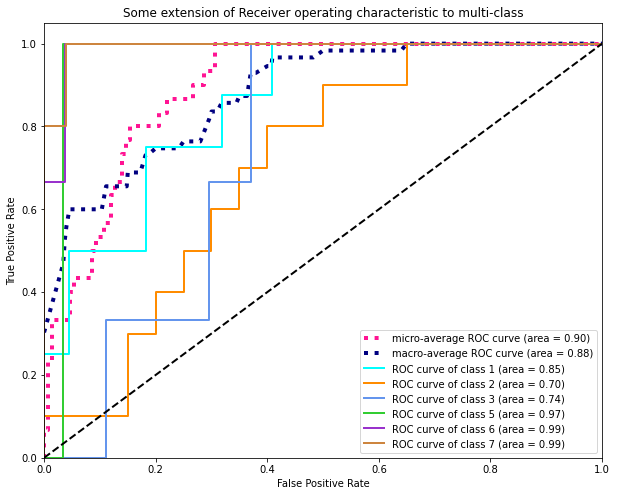

In [8]:

from sklearn.linear_model import LogisticRegression
ref_model = LogisticRegression(C=1).fit(X_train, Y_train)

print_scores(ref_model,X_train, X_test, Y_train, Y_test, '[ Logistic regression (benchmark)]')
plot_roc(ref_model, X_test, Y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from math import log10


param_grid = {'C': np.arange(0.8,1.1,0.01)}
model = LogisticRegression()
cv = GridSearchCV(model, param_grid, scoring="balanced_accuracy", cv=11)
cv.fit(X_train, Y_train)
cv.best_estimator_

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion="entropy", max_depth=15, min_samples_leaf=7).fit(X_train, Y_train)

print_scores(model,X_train, X_test, Y_train, Y_test, '[ Decision tree]')
plot_roc(model, X_test, Y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced', max_depth=30, min_samples_split=3,random_state=989, n_estimators=1000).fit(X_train, Y_train)
#model = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                        # max_depth=13, max_features=1, min_samples_split=4,
                        # n_jobs=-1, random_state=989, n_estimators=1000).fit(X_train, Y_train)
# model = RandomForestClassifier(class_weight='balanced', max_depth=12.0,
#                        max_features='sqrt',
#                        min_samples_split=0.30000000000000004, n_jobs=-1,
#                        random_state=989).fit(X_train, Y_train)
print_scores(model,X_train, X_test, Y_train, Y_test, '[ Random forest]')
plot_roc(model, X_test, Y_test)

import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=X.columns, y=model.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from math import log10
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score

scoring = {'f1_micro': 'f1_micro', 'balanced_accuracy': make_scorer(balanced_accuracy_score)}

param_grid = {'n_estimators': [50, 80, 100], 'max_depth': [5, 10, 20], 'min_samples_split': [5, 10, 15, 20]}
param_grid2 = {'max_depth': np.arange(12,14,0.5), 'criterion' : ['entropy', 'gini'],'max_features': ['sqrt', 'auto', 1], 'min_weight_fraction_leaf' : np.logspace(log10(1e-4),log10(1e-1),10) }

model = RandomForestClassifier(random_state=989, n_jobs=-1, class_weight='balanced', min_samples_split=4)
cv = GridSearchCV(model, param_grid2, scoring=scoring, refit='balanced_accuracy', return_train_score=True)
cv.fit(X, Y)
print("Best score:", cv.best_score_)
cv.best_estimator_

In [ ]:
np.logspace(log10(1e-4),log10(1e-1),10)

In [ ]:
import matplotlib.pyplot as plt
results = cv.cv_results_
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
#ax.set_xlim(0, 402)
#ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model_dtc = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',max_depth=6, max_features=5, max_leaf_nodes=9,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
model_dtc.fit(X_train, Y_train)
print_scores(model_dtc,X_train, X_test, Y_train, Y_test, '[ Juan Decision tree ]')
plot_roc(model_dtc, X_test, Y_test)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import label_binarize
Y_c3 = label_binarize(Y, classes=[3])
Y_train_c3 = label_binarize(Y_train, classes=[3])
Y_test_c3 = label_binarize(Y_test, classes=[3])
base_estimator=RandomForestClassifier(max_depth=32,min_samples_split=3,n_estimators=80)
model = AdaBoostClassifier(base_estimator=base_estimator,
                   learning_rate=0.1, n_estimators=100)
model.fit(X_train, Y_train_c3)
print_scores(model,X_train, X_test, Y_train_c3, Y_test_c3, '[ Juan Decision tree ]')
plot_roc(model, X_test, Y_test_c3)

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

est_AB = XGBClassifier()
score_AB=est_AB.fit(X_train,Y_train).score(X_test,Y_test)

est_RF = RandomForestClassifier(class_weight='balanced', max_depth=30, min_samples_split=3, n_estimators=10000)
score_RF=est_RF.fit(X_train,Y_train).score(X_test,Y_test)

est_Ensemble = VotingClassifier(estimators=[('XGB', est_AB), ('RF', est_RF)],
                        voting='soft',
                        weights=[1.5,0.5])

est_Ensemble.fit(X_train,Y_train)
print_scores(est_Ensemble,X_train, X_test, Y_train, Y_test, '[ Voting ]')
plot_roc(est_Ensemble, X_test, Y_test)

In [ ]:
scoring = {'f1_micro': 'f1_micro', 'balanced_accuracy': make_scorer(balanced_accuracy_score)}

param_grid = {'n_estimators': [50, 80, 100], 'base_estimator': [est_RF, model_dtc,None], 'learning_rate': [0.1, 1, 1.1, 0.5]}
model = AdaBoostClassifier()
cv = GridSearchCV(model, param_grid, scoring='balanced_accuracy', refit=True, return_train_score=True)
cv.fit(X, Y)
cv.best_estimator_

In [ ]:
cv.cv_results_

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.5,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=6,
                    seed=989)
model.fit(X_train, Y_train)
print_scores(model,X_train, X_test, Y_train, Y_test, '[ XGBOOST ]')
plot_roc(model, X_test, Y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from math import log10
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score
from xgboost import XGBClassifier

scoring = {'f1_micro': 'f1_micro', 'balanced_accuracy': make_scorer(balanced_accuracy_score)}

#param_grid_ref = {'max_depth': np.arange(12,14,0.5), 'criterion' : ['entropy', 'gini'],'max_features': ['sqrt', 'auto', 1], 'min_weight_fraction_leaf' : np.logspace(log10(1e-4),log10(1e-1),10) }

paramgrid = {'max_depth': np.arange(3,14,1), 'n_estimators':np.arange(15,30,1)}
model = XGBClassifier()
cv = GridSearchCV(model, paramgrid, scoring='balanced_accuracy', return_train_score=True)
cv.fit(X_train, Y_train)
print("Best score:", cv.best_score_)
print("Best param:", cv.best_params_)
cv.best_estimator_

In [ ]:
X

In [10]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score,balanced_accuracy_score

#allow logloss and classification error plots for each iteraetion of xgb model
def plot_compare(metrics,eval_results):
    for m in metrics:
        test_score = eval_results['validation_1'][m]
        train_score = eval_results['validation_0'][m]
        rang = range(0, len(test_score))
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()
        
def fitXgb(sk_model,epochs=300):
    print('Fitting model...')
    sk_model.fit(X_train, Y_train)
    print('Fitting done!')
    train = xgb.DMatrix(X_train, label=Y_train)
    val = xgb.DMatrix(X_test, label=Y_test)
    params = sk_model.get_xgb_params()
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
    print('-- Model Report --')
    print('XGBoost Accuracy: '+str(accuracy_score(Y_test, sk_model.predict(X_test))))
    print('XGBoost Balanced Accuracy: '+str(balanced_accuracy_score(Y_test, sk_model.predict(X_test))))
    print('XGBoost F1-Score (Micro): '+str(f1_score(Y_test, sk_model.predict(X_test),average='micro')))
    plot_compare(metrics,store)
    features = X.columns
    f, ax = plt.subplots(figsize=(10,5))
    plot = sns.barplot(x=features, y=sk_model.feature_importances_)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()
    return xgb_model

def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

[0]	validation_0-mlogloss:1.36099	validation_0-merror:0.16092	validation_1-mlogloss:1.49301	validation_1-merror:0.36667
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.09525	validation_0-merror:0.16092	validation_1-mlogloss:1.32730	validation_1-merror:0.33333
[2]	validation_0-mlogloss:0.91087	validation_0-merror:0.12644	validation_1-mlogloss:1.23523	validation_1-merror:0.36667
[3]	validation_0-mlogloss:0.75716	validation_0-merror:0.06897	validation_1-mlogloss:1.12248	validation_1-merror:0.36667
[4]	validation_0-mlogloss:0.63392	validation_0-merror:0.03448	validation_1-mlogloss:1.01621	validation_1-merror:0.33333
[5]	validation_0-mlogloss:0.54191	validation_0-merror:0.02299	validation_1-mlogloss:0.92790	validation_1-merror:0.30000
[6]	validation_0-mlogloss:0.46341	validation_0-merror:0.02299	validation_1-mlogloss:0.88354	validation_1-merror:0.333

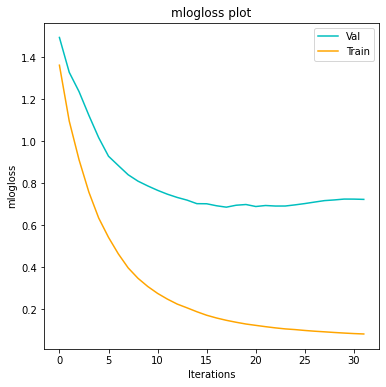

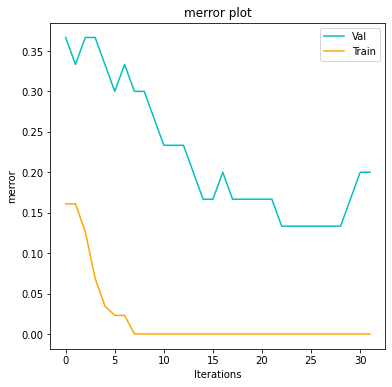

                [ XGBOOST ]
Default score: ----------------------------------------------------------------------
 Train: 1.000
 Test: 0.867
Other scores: ----------------------------------------------------------------------
 Accuracy  : 0.867
             [1 2 3 5 6 7]
 Precision : [0.8 0.8 1.  1.  1.  1. ]
 Recall    : [1.         0.8        0.66666667 1.         0.66666667 1.        ]
 F1        : [0.88888889 0.8        0.8        1.         0.8        1.        ]
 F1 micro  : 0.867
 F1 macro  : 0.881
 Balanced accuracy: 0.856
-------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.80      1.00      0.89         8
           2       0.80      0.80      0.80        10
           3       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         1
           6       1.00      0.67      0.80         3
           7       1.00      1.00      1.00         

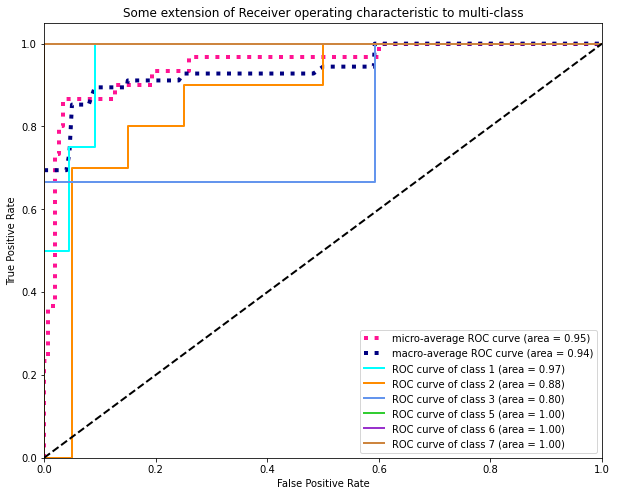

In [15]:
from xgboost.sklearn import XGBClassifier
#initial model
# xgb1 = XGBClassifier(learning_rate=0.01,
#                     n_estimators=1000,
#                     max_depth=7,
#                     min_child_weight=1,
#                     gamma=0,
#                     reg_alpha=0.01,
#                     subsample=0.8,
#                     colsample_bytree=0.5,
#                     objective='multi:softmax',
#                     nthread=4,
#                     num_class=6,
#                     seed=989)

xgb1 = XGBClassifier(objective='multi:softmax',
                        num_class=6,
                        max_depth=4,
                        gamma = 1e-06,
                        random_state=989)

xgb1.fit(X_train, Y_train,
         eval_set=[(X_train, Y_train), (X_test, Y_test)],
         eval_metric=['mlogloss','merror'],
         verbose=True,
         early_stopping_rounds=10)
plot_compare(['mlogloss','merror'],xgb1.evals_result())
print_scores(xgb1,X_train, X_test, Y_train, Y_test, '[ XGBOOST ]')
plot_roc(xgb1, X_test, Y_test)

In [ ]:
xgb1.evals_result()

In [14]:
from sklearn.model_selection import GridSearchCV

xgb_gs = XGBClassifier(objective='multi:softmax',
                        num_class=6)

param_test1 = {
 'max_depth':range(3,10,1),
 #'min_child_weight':range(1,6,2),
 'colsample_bytree': [0.1, 0.25, 0.5, 0.7, None],
 'reg_lambda':[1e-9, 1e-8, 1e-7, 1e-6],
 'gamma':[1e-6, 1e-4, 1e-3]
}
#metrics to consider: f1_micro, f1_macro, roc_auc_ovr
gsearch1 = GridSearchCV(estimator = xgb_gs, param_grid = param_test1, scoring='balanced_accuracy',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(X_train, Y_train,
         eval_set=[(X_train, Y_train), (X_test, Y_test)],
         eval_metric=['mlogloss','merror'],
         verbose=True,
         early_stopping_rounds=200)
getTrainScores(gsearch1)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:

3: "mean:0.5042539682539682params{'colsample_bytree': 0.7, 'gamma': 1e-06, 'max_depth': 3, 'reg_lambda': 1e-08}",
  254: "mean:0.5042539682539682params{'colsample_bytree': 0.7, 'gamma': 1e-06, 'max_depth': 3, 'reg_lambda': 1e-07}",
  255: "mean:0.5042539682539682params{'colsample_bytree': 0.7, 'gamma': 1e-06, 'max_depth': 3, 'reg_lambda': 1e-06}",
  256: "mean:0.5453650793650794params{'colsample_bytree': 0.7, 'gamma': 1e-06, 'max_depth': 4, 'reg_lambda': 1e-09}",
  257: "mean:0.5453650793650794params{'colsample_bytree': 0.7, 'gamma': 1e-06, 'max_depth': 4, 'reg_lambda': 1e-08}",
  258: "mean:0.5453650793650794params{'colsample_bytree': 0.7, 'gamma': 1e-06, 'max_depth': 4, 'reg_lambda': 1e-07}",
  259: "mean:0.5453650793650794params{'colsample_bytree': 0.7, 'gamma': 1e-06, 'max_depth': 4, 'reg_lambda': 1e-06}",
  260: "mean:0.4853650793650794params{'colsample_bytree': 0.7, 'gamma': 1e-06, 'max_depth': 5, 'reg_lambda': 1e-09}",
  261: "mean:0.4853650793650794params{'colsample_bytree': 0.

In [ ]:
X_train.shape

In [ ]:
X_train